<a href="https://colab.research.google.com/github/ihagoSantos/natural-language-processing/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de textos


In [1]:
# Instalação dos pacotes necessários
!pip install nltk==3.8.1
!pip install unidecode==1.3.8
!pip install scikit-learn==1.5.2
!pip install pandas==2.2.2
!pip install wordcloud==1.9.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
      Successfully uninstalled nltk-3.9.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.9.4
    Uninstalling wordcloud-1.9.4:
      Successfully uninstalled wordcloud-1.9.4


In [2]:
# Importação das bibliotecas padrão
import datetime
import math
import pickle
import re
import string
import sys
import warnings

# Importação das bibliotecas de terceiros
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from unidecode import unidecode
from wordcloud import WordCloud

# Downloads do NLKT
nltk.download('punkt')
nltk.download('stopwords')

# Configurações e comandos específicos
warnings.filterwarnings('ignore')

print("Pacotes importados e prontos para uso")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...


Pacotes importados e prontos para uso


[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def preprocessa_texto(texto):
  """
  Preprocessa o texto fornecido realizando várias etapas de limpeza

  Etapas:
  1. Tokeniza o texto
  2. Converte os tokens para minusculo
  3. Remove stopwords em português
  4. Remove números dos tokens
  5. Exclui tokens que são pontuações
  6. Remove acentuações dos tokens

  Parâmetros:
  texto (str): O texto a ser preprocessado

  Retorna:
  list: Lista de tokens preprocessados
  """

  # Tokeniza o texto usando um padrão para capturar palavras e pontuações.
  padrao = r"\w+(?:'\w+)?|[^\w\s]"
  tokens_preprocessados = re.findall(padrao, texto)

  # Converte o texto para minúsculo para padronizar a capitalização
  tokens_preprocessados = [token.lower() for token in tokens_preprocessados]

  # Remove stopwords para reduzir o conjunto de tokens a palavras significativas
  portugues_stops = stopwords.words('portuguese')
  tokens_preprocessados = [token for token in tokens_preprocessados if token not in portugues_stops]

  # Remove números, pois geralmente não contribuem para o significado do texto
  tokens_preprocessados = [re.sub(r'\d+', '', token) for token in tokens_preprocessados if re.sub(r'\d+', '', token)]

  # Exclui tokens que são pontuações, pois raramente são úteis par análise de texto
  tokens_preprocessados = [token for token in tokens_preprocessados if token not in string.punctuation]

  # Remove acentuações para padronizar os tokens
  tokens_preprocessados = [unidecode(token) for token in tokens_preprocessados]

  return ' '.join(tokens_preprocessados)

# Metodologia

A metodologia deste projeto está dividida nas etapas do processo padrão de mineração de dados denominado **Cross Industry Process for Data Mining (CRISP-DM)**. O modelo CRISP-DM define um conjunto comuns de etapas, tarefas e entregáveis necessários para a realização bem sucedida de um projeto de mineração de dados. Esse Modelo possui seis etapas principais:

## 1. Entendimento do Negócio
Nessa etapa, é necessário entender o problema abordado e as questões relacionadas a ele. No contexto desse projeto, a questão primária a ser respondida é:

> Por meio das técnicas de Aprendizado de Máquina (AM) e Processamento de Linguagem Natural (PLN), é possível predizer a legibilidade de um texto com alta precisão?

## 2. Entendimento dos Dados

Nesta etapa, é necessário avaliar os dados disponíveis ou se é necessário coletar dados para responder às perguntas levantadas na etapa de entendimento do negócio. \\
O modelo de predição será desenvolvido a partir de uma base de dados utilizada na competição *CommonLit Readability Prize* promovida pela Kaggle e patrocinada pela empresa *CommonLit, Inc*. e pelo *Departamento de Linguistica da Georgia State University*.

### Descrição da base de dados
1. **id**: Identificador para trecho do texto
2. **url_legal**: URL da fonte do trecho do texto
3. **license**: Licença de uso do trecho do texto
4. **excerpt**: Trecho do texto avaliado
5. **target**: Legibilidade do trecho do texto
6. **standard_error**: medida de dispersão das pontuações entre múltiplos avaliadores para cada trecho. Não inclui dados de testes



## 2.1. Coleta de Dados

In [4]:
# URL para download dos dados de treinamento
URL_PATH = (
    "https://raw.githubusercontent.com/gomesluiz/"
    "commonlit-readability-predicting/main/datasets/train.csv"
)

trechos = pd.read_csv(URL_PATH, usecols=["excerpt", "target"])

trechos.columns = ["trecho", "legibilidade"]

print(f"Estatística da coluna Legibilidade: \n{trechos['legibilidade'].describe()}")

Estatística da coluna Legibilidade: 
count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: legibilidade, dtype: float64


In [5]:
# Categoriza a coluna 'legibilidade' com base em intervalos de valores
legibilidade_categorias=["Muito Dificil", "Dificil", "Moderadamente Dificil", "Padrão", "Bastante Facil", "Facil"]
trechos['legibilidade_categoria'] = pd.cut(
    trechos['legibilidade'],
    bins=[-4.00, -3.00, -2.00, -1.00, 0.00, 1.00, 2.00],
    labels=legibilidade_categorias
)

# Exibe os dez primeiros registros do DataFrame
trechos.head(10)

,trecho,legibilidade,legibilidade_categoria
0,When the young people returned to the ballroom...,-0.340259,Padrão
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,Padrão
2,"As Roger had predicted, the snow departed as q...",-0.580118,Padrão
3,And outside before the palace a great garden w...,-1.054013,Moderadamente Dificil
4,Once upon a time there were Three Bears who li...,0.247197,Bastante Facil
5,Hal and Chester found ample time to take an in...,-0.861809,Padrão
6,Hal Paine and Chester Crawford were typical Am...,-1.759061,Moderadamente Dificil
7,"On the twenty-second of February, 1916, an aut...",-0.952325,Padrão
8,The boys left the capitol and made their way d...,-0.371641,Padrão
9,One day he had gone beyond any point which he ...,-1.238432,Moderadamente Dificil


## 2.2. Análise Exploratória dos Dados

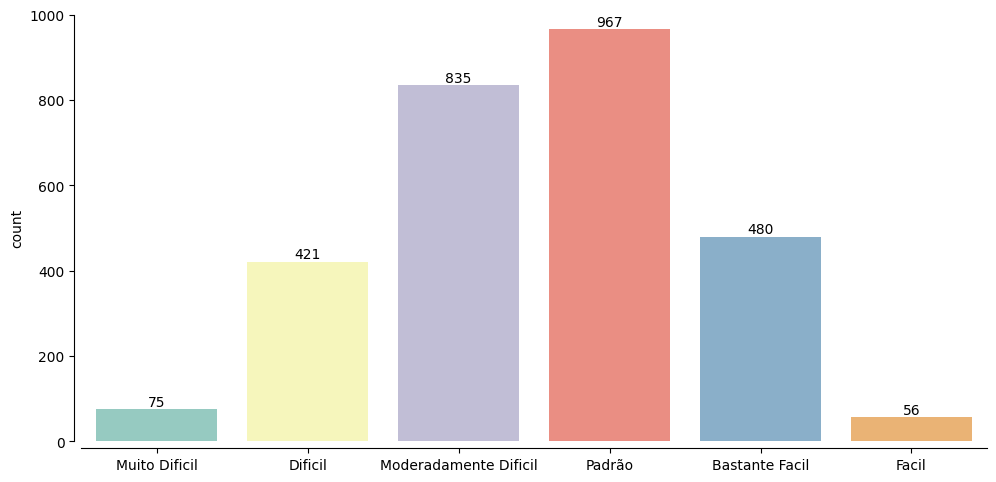

In [6]:
g=sns.catplot(
    data=trechos,
    x="legibilidade_categoria",
    height=5,
    aspect=2,
    kind='count',
    palette='Set3',
    legend=False
)

for ax in g.axes.flat:
  for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

sns.despine(offset=5)

g.set(ylim=(0,1000))
g.set(xlabel=None)

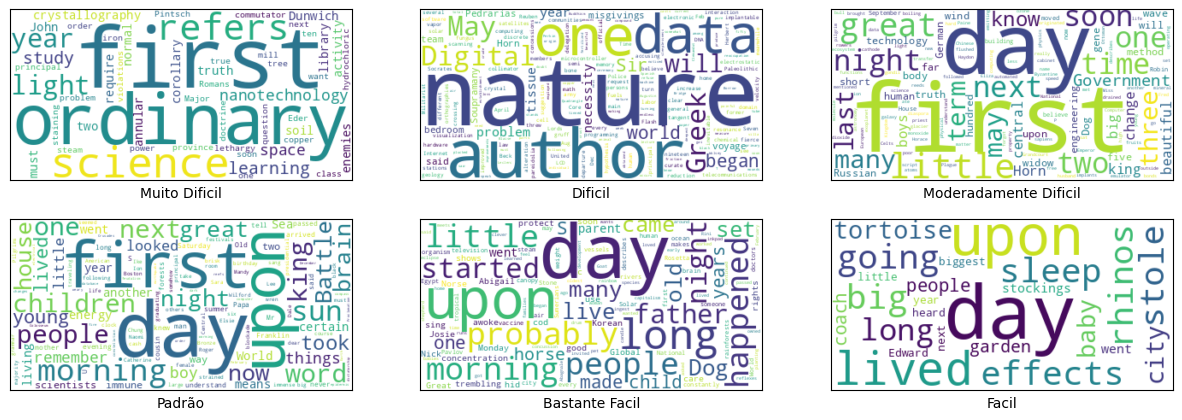

In [7]:
# O balanceamento dos dados será feito no futuro

linhas,colunas=2,3
conta_linha,conta_coluna=0,0
fig,ax = plt.subplots(linhas,colunas, sharex='col', sharey='row',figsize=(15,5))

for categoria in legibilidade_categorias:
  textos = trechos[(trechos.legibilidade_categoria == categoria)].trecho
  words = " ".join([texto.split()[1] for texto in textos])

  word_cloud = WordCloud(collocations=False, background_color='white').generate(words)
  ax[conta_linha, conta_coluna].imshow(word_cloud, interpolation='bilinear')
  ax[conta_linha, conta_coluna].set_xticks(())
  ax[conta_linha, conta_coluna].set_yticks(())
  ax[conta_linha, conta_coluna].set(xlabel=categoria)

  conta_coluna += 1
  if conta_coluna > 2:
    conta_linha += 1
    conta_coluna = 0

plt.show()

## 3. Preparação dos Dados
O objetivo desta etapa do CRISP-DM é limpar e transformar os dados em um formato adequado para o treinamento do modelo.

In [8]:
# Pré-processa os trechos dos textos
trechos['trecho_preprocessado'] = trechos['trecho'].apply(preprocessa_texto)
trechos.head()

,trecho,legibilidade,legibilidade_categoria,trecho_preprocessado
0,When the young people returned to the ballroom...,-0.340259,Padrão,when the young people returned to the ballroom...
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,Padrão,all through dinner time mrs fayre was somewhat...
2,"As Roger had predicted, the snow departed as q...",-0.580118,Padrão,roger had predicted the snow departed quickly ...
3,And outside before the palace a great garden w...,-1.054013,Moderadamente Dificil,and outside before the palace great garden was...
4,Once upon a time there were Three Bears who li...,0.247197,Bastante Facil,once upon time there were three bears who live...


## 3.5 Vetorização

In [9]:
# Divide o Dataset em trechos de treinamento e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(trechos['trecho_preprocessado'], trechos['legibilidade_categoria'], test_size = .25, random_state=32)

In [10]:
# Vetoriza os conjuntos de treinamento
vetorizador = CountVectorizer(max_features=1000) # mil palavras mais frequentes
X_train_vetorizado = vetorizador.fit_transform(X_train)
X_train_vetorizado = pd.DataFrame(X_train_vetorizado.toarray(), columns=vetorizador.get_feature_names_out())
X_train_vetorizado.index = X_train_vetorizado.index
X_train_vetorizado.head()

,ability,able,about,above,according,account,across,act,action,activity,...,written,wrong,year,years,yellow,yes,yet,you,young,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Vetoriza o conjunto de testes
X_test_vetorizado = vetorizador.transform(X_test) # usa método 'transform' no lugar de 'fit_transform' para obter o mesmo conjunto de palavras dos dados de treinamento. Senão, não é possível avaliar o modelo posteriormente
X_test_vetorizado = pd.DataFrame(X_test_vetorizado.toarray(), columns=vetorizador.get_feature_names_out())
X_test_vetorizado.index = X_test_vetorizado.index
X_test_vetorizado.head()

,ability,able,about,above,according,account,across,act,action,activity,...,written,wrong,year,years,yellow,yes,yet,you,young,your
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


## 4. Treinamento do Modelo (Modelagem)
O objetivo desta etapa é construir e treinar o modelo para resolver o problema de negócio.



In [14]:
# Treina o modelo com o classificador MultinomialNB para estabelecimento de um baseline
clf = MultinomialNB() # classificador popularmente utilizado em classificação de textos e também para estabelecer modelos de baseline
_ =clf.fit(X_train_vetorizado, y_train)
print("Modelo baseline treinado")

Modelo baseline treinado


## 5. Avaliação do Modelo
O objetivo desta etapa é avaliar o desempenho dos modelos de aprendizagem e determinar se eles são adequados para resolver os problemas de negócio


## 5.1. Teste do modelo

In [15]:
y_pred = clf.predict(X_test_vetorizado)
print("Modelo baseline testado")

Modelo baseline testado


## 5.2. Avaliação dos resultados

In [16]:
print(f"Métricas do modelo base:\n\n{classification_report(y_test, y_pred)}")

Métricas do modelo base:

                       precision    recall  f1-score   support

       Bastante Facil       0.39      0.52      0.45       103
              Dificil       0.42      0.58      0.49       116
                Facil       0.11      0.06      0.08        17
Moderadamente Dificil       0.43      0.34      0.38       204
        Muito Dificil       0.08      0.31      0.12        13
               Padrão       0.48      0.34      0.40       256

             accuracy                           0.40       709
            macro avg       0.32      0.36      0.32       709
         weighted avg       0.42      0.40      0.40       709



## 6. Implantação do modelo
O objetivo desta etapa é implementar os modelos de mineração de dados escolhidos na fase anterior e integrá-los ao processo de negócio.

In [17]:
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
arquivo = f"{timestamp}-modelo_predicao_legibilidade.sav"
pickle.dump(clf, open(arquivo,'wb'))
print("Modelo baseline gravado para implantação")
# Ver mais sobre lib pickle: https://www.hashtagtreinamentos.com/python-pickle-perpetuar-objetos-no-python

Modelo baseline gravado para implantação
